<a href="https://colab.research.google.com/github/RFuentesAlbornoz/MachingLearning_UTAL/blob/main/ProyectoML_RFuentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión de Datos Misteriosos
**Roberto M. Fuentes, roberto.fuentes@utalca.cl**

---



En el contexto del curso Machine Learning, se propuso el proyecto final que involucra la obtención de un modelo de regresión entrenado con datos sin una explicación de su procedencia. Se debe plantear una hipotesis de acuerdo a estos datos y luego ponerla a prueba con el modelo creado.


**Hipotesis**

Dado un conjunto de datos de procedencia desconocida con mucha mayor cantidad de columnas que filas (rows << columns), es posible realizar un modelo de regresión lineal empleando un metodo de reducción de la dimensionalidad que obtenga un resultado aceptable.

**Adquisión de datos**

Se realiza la carga del dataset proveniente desde un weblink.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Cargar dataset
df = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1cJZIUTPoYliSej8ZQumPdrvWjcZeRyuEqyC4JyXpx-8' +
                   '/export?format=csv'
                  )
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480
0,0.0,945.88,949.46,948.32,947.63,949.00,949.16,947.64,947.41,948.39,...,3.72,3.95,4.11,3.93,3.98,3.90,3.79,4.25,3.90,4.19
1,-5.4,944.01,947.31,946.31,945.52,947.21,947.31,945.53,945.26,946.10,...,3.62,3.90,4.08,3.86,3.97,3.86,3.75,4.18,3.82,4.11
2,-5.3,943.91,947.14,946.49,945.53,947.09,946.76,945.36,945.10,946.13,...,3.70,3.93,4.11,3.88,3.98,3.86,3.74,4.23,3.88,4.13
3,-4.7,943.01,946.28,945.35,944.15,946.20,945.86,944.16,944.33,944.72,...,3.70,3.89,4.05,3.85,3.97,3.86,3.73,4.20,3.80,4.11
4,-4.7,942.37,946.24,945.08,944.30,945.94,945.83,944.55,944.04,944.58,...,3.65,3.89,4.07,3.86,3.86,3.83,3.76,4.17,3.83,4.17


**Identificación de anomalía en los datos**

Se utilizan comandos para la detección de datos faltantes, NaN o duplicados. Al no encontrar ninguno, no es necesario amputar esas columnas.

In [2]:
#Identificación de datos nulos o duplicados

dfnull = df.isnull().values.sum()
dfdup = sum(df.duplicated())
print("Existen {} elementos nulos y {} elementos duplicados en el dataset".format(dfnull, dfdup))

Existen 0 elementos nulos y 0 elementos duplicados en el dataset


**Normalización y eliminación de filas con outliers**

Una vez se posee un dataframe sin datos faltantes o anomalías, se procede a normalizar para atenuar los problemas ocacionados por la diferencia de escalas entre caracteristicas del df.
Una vez normalizado, se pueden identificar los outliers. Para este caso, se emplea el algoritmo de IsolationForest para la detección de outliers, los cuales se descartan del df posteriormente.

In [3]:
#Normalizar para identificar outliers mediante IForest
import scipy.stats as stats
from sklearn.ensemble import IsolationForest

#Aplicar la normalización zscore en cada columna individual de manera manual
df_norm = df.drop(columns=['Y'])
stdx = np.zeros(len(df_norm.index))
meanx = np.zeros(len(df_norm.index))
for i in range(len(df_norm.index)):
  stdx[i] = np.std(df_norm.iloc[:,i])
  meanx[i] = np.mean(df_norm.iloc[:,i])
  df_norm.iloc[:,i] = (df_norm.iloc[:,i]-meanx[i]).div(stdx[i])

# Obtener los outliers a partir de cada columna del df normalizado
model = IsolationForest(contamination = 0.05).fit(df_norm)
result = model.predict(df_norm)
result

idx_outliers = []
for idx in range(len(result)):
    if result[idx] < 0:
        idx_outliers.append(idx)

print('Las filas {} se eliminan por contener datos atipicos.'.format(idx_outliers))

Las filas [4, 18, 40] se eliminan por contener datos atipicos.


Las filas identificadas con outliers se eliminan del df original, para luego re-normalizar, obtiendo así un df normalizado sin influencia de outliers, y sin problemas de diferencias en las escalas.

In [4]:
# Se eliminan las filas en el df original y se re-normaliza
df2 = df.drop(index=idx_outliers)
df2.reset_index(drop=True, inplace=True)

# Se renormaliza posterior al descarte de outliers
train = df2.drop(columns=['Y'])
stdx = np.zeros(len(train.index))
meanx = np.zeros(len(train.index))
for i in range(len(train.index)):
  stdx[i] = np.std(train.iloc[:,i])
  meanx[i] = np.mean(train.iloc[:,i])
  train.iloc[:,i] = (train.iloc[:,i]-meanx[i]).div(stdx[i])

# Se separan las caracteristicas de la variable dependiente
X = train
y = df2.Y

**Reducción de dimensionalidad y visualización del df**

Se emplea el metodo PCA para la reducción de la dimensionalidad. Este metodo es configurado para que identifique los PC que expliquen el 95% de la varianza. De esta forma, se reduce la cantidad de columnas, descartando las que menos aportan a la variación de los datos.

[0.87647833 0.06066284 0.0208963 ]
[0.87647833 0.93714118 0.95803748]


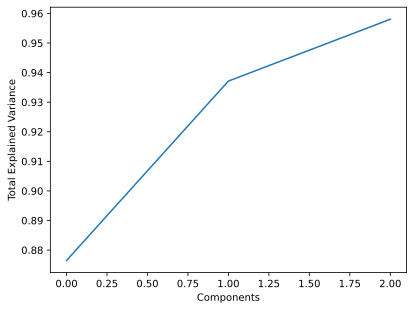

In [5]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

pca = PCA(0.95) # Se ajusta el PCA para que explique el 95%

# Se separan los datos de test y de trainning
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# Se obtienen los PC y se grafica
pca.fit(X_train)
N = pca.components_.shape[0] # Se identifica el numero de PCs obtenidos
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.ylabel('Total Explained Variance')
plt.xlabel('Components')
plt.show()

# Se obtienen los vectores reducidos de test y trainning
X_reduced_train = pd.DataFrame(pca.transform(X_train), columns=['PC%s' % _ for _ in range(N)])
X_reduced_test = pd.DataFrame(pca.transform(X_test), columns=['PC%s' % _ for _ in range(N)])

Se aprecia que para explicar más del 95% del ratio de varianza, se requieren 3 PCs, por lo tanto, se reduce de 480 columnas, a solo 3, los cuales conformarán al df que se usará para entrenar al modelo.
Estos PCs más relevantes son gráficados a continuación.

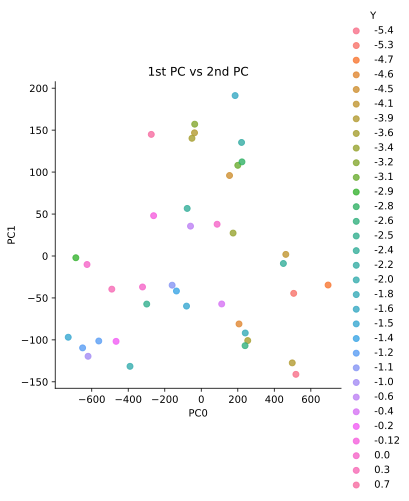

In [6]:
# Se grafican los dos PCs mas relevantes a partir de los datos normalizados
pca_df = pd.DataFrame(pca.transform(X),columns=['PC%s' % _ for _ in range(N)])
pca_df['Y'] = y

fig = sns.lmplot(x='PC0', y='PC1', data=pca_df, hue='Y',fit_reg=False)
plt.title('1st PC vs 2nd PC')
plt.show()

**Regresión**

Posterior a obtener el df normalizado y reducido, se comienza con el entrenemiento de los modelos de regresión. Para este caso se utilizará LinearRegression y SVR, ambos disponibles en sklearn.

El primer modelo utilizado es **LinearRegression**. A continuación se muestra el resultado:

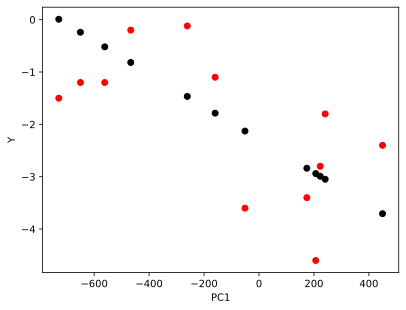

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() # Se crea un modelo de regresion lineal
model.fit(X_reduced_train.iloc[:,:1], y_train)

# Se predice y grafica modelo
y_pred = model.predict(X_reduced_test.iloc[:,:1])

y_test.reset_index(drop=True, inplace=True)
X_reduced_test.reset_index(drop=True, inplace=True)

plt.scatter(X_reduced_test.iloc[:,0], y_test,color = 'red')
plt.scatter(X_reduced_test.iloc[:,0], y_pred, color = "black")
plt.xlabel("PC1")
plt.ylabel("Y")
plt.show()

La mayorias de metricas disponibles en sklearn.metrics para medir el desempeño  se basan en el error con las diferencias en cómo se opera con el error. Esto permite penalizar distintos aspectos, tal como puede ser la penalización por un valor mayor del error cuadratico, o el caso contrario con el error logaritmico, que penaliza casi independientemente del valor, ya que se debe aumentar el error en ordenes de magnitud para visualziar diferencias notables.
Por otro lado, estan los que utilizan metricas distintas, tal como el coeficiente de determinación que penalizan en función de la varianza en la variable objetivo, o basados en la desviación estandar, etc.

En este caso se emplean las metricas de MSE, R2 y Pinball D2 con los siguientes resultados:

In [8]:
# Calcular metricas
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance, d2_pinball_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
d2_pinb = d2_pinball_score(y_test, y_pred)

# Mostrar estadisticas de desempeño
print("Error cuadrático medio:", round(mse,4))
print("Coeficiente de determinación R^2:", round(r2,4))
print("Función de pérdida Pinball para regresión D^2:", round(d2_pinb,4))

Error cuadrático medio: 1.2383
Coeficiente de determinación R^2: 0.3002
Función de pérdida Pinball para regresión D^2: 0.0785


In [9]:
# Cross-validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_reduced_train, y_train, cv=5)
print("Tras aplicar una validación cruzada se obtiene %0.2f de precisión con una desviación estándar de %0.2f" % (scores.mean(), scores.std()))


Tras aplicar una validación cruzada se obtiene -0.20 de precisión con una desviación estándar de 1.27


El segundo modelo utilizado es **SVR**. A continuación se muestra el resultado:

Error cuadrático medio: 1.3671
Coeficiente de determinación R^2: 0.2274
Función de pérdida Pinball para regresión D^2: 0.0347


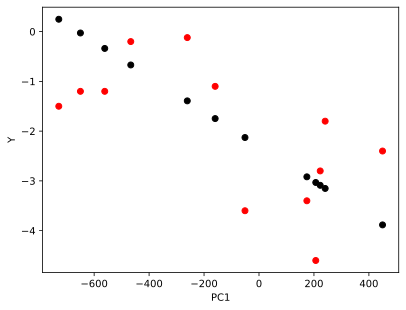

In [10]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'linear')
regressor.fit(X_reduced_train.iloc[:,:1], y_train)
y_pred = regressor.predict(X_reduced_test.iloc[:,:1])

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
d2_pinb = d2_pinball_score(y_test, y_pred)

# Mostrar estadisticas de desempeño
print("Error cuadrático medio:", round(mse,4))
print("Coeficiente de determinación R^2:", round(r2,4))
print("Función de pérdida Pinball para regresión D^2:", round(d2_pinb,4))



plt.scatter(X_reduced_test.iloc[:,0], y_test,color = 'red')
plt.scatter(X_reduced_test.iloc[:,0], y_pred, color = "black")
plt.xlabel("PC1")
plt.ylabel("Y")
plt.show()



In [11]:
# Cross-validation

scores = cross_val_score(regressor, X_reduced_train, y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


-0.59 accuracy with a standard deviation of 1.64


Para este caso, se aprecian unos resultados similares que los obtenidos con el modelo de RegresionLinear.

**Conclusion**

 Recordando que un valor menor del MSE, un valor más cercano a 1 para el R2, y un valor mayor del D2, indican un mejor desempeño, se aprecia una leve superioridad del modelo de RegressionLinear. Ambos modelos permiten predecir de una manera aceptable (pero mejorable) los datos de test del sistema, incluso considerando la reducción de dimensionalidad.

In [13]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('ProyectoML_RFuentes.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern '$notebookpath$file_name' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y

'File Download Unsuccessful. Saved in Google Drive'